In [17]:
from xml.etree import ElementTree as ET
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re

In [18]:
import inlp.convert.chinese as cv
print(cv.s2t('忧郁的台湾乌龟'))
print(cv.t2s('憂郁的臺灣烏龜'))

憂郁的臺灣烏龜
忧郁的台湾乌龟


In [19]:
def is_weibo(i):
    flag1 = True if '@'in i or 'http' in i or '原文转发' in i or '原文评论' in i or '(回复)' in i or '(转发微博)' in i or '转发理由:' in i or '分享自' in i else False
    topic_pattern = r'#[\u4e00-\u9fa5a-zA-Z0-9]+?#'# 话题过滤
    flag2 = True if re.search(topic_pattern,i) else False
    return flag1 or flag2

### 读入数据

In [20]:
tree = ET.parse("../dataset/SMP2019_ECISA_Train.xml")
root = tree.getroot()

train_dataset = []
for i in root.iter('Doc'):
    all_text = ' '.join([j.text for j in i.iter('Sentence')])
    for j in i.iter('Sentence'):
        if j.get('label') is not None:
            train_dataset.append([i.get('ID'),j.get('ID'),all_text,j.text,int(j.get('label'))])
train_dataset = pd.DataFrame(train_dataset,columns=['Doc_id','Sen_id','All_text','Text','Label'])
train_dataset['Is_weibo'] = train_dataset['All_text'].apply(is_weibo)

In [21]:
train_dataset['Is_weibo'].value_counts()

False    9207
True     5581
Name: Is_weibo, dtype: int64

In [22]:
tree = ET.parse("../dataset/SMP2019_ECISA_Dev.xml")
root = tree.getroot()

dev_dataset = []
for i in root.iter('Doc'):
    all_text = ' '.join([j.text for j in i.iter('Sentence')])
    for j in i.iter('Sentence'):
        if j.get('label') is not None:
            dev_dataset.append([i.get('ID'),j.get('ID'),all_text,j.text,int(j.get('label'))])
dev_dataset = pd.DataFrame(dev_dataset,columns=['Doc_id','Sen_id','All_text','Text','Label'])
dev_dataset['Is_weibo'] = dev_dataset['All_text'].apply(is_weibo)

In [23]:
dev_dataset['Is_weibo'].value_counts()

False    3220
True     1925
Name: Is_weibo, dtype: int64

### 正则过滤

In [26]:
pic_pattern = open('pic_pattern.txt','r').read().replace('\n','|')
def pattern_filting(df):
    for t in [['Text','Label'],['All_text','Label']]:
        for index,item in enumerate(df[t].values.tolist()):
            i = item[0]
            j = item[1]

            if 'http'in i:
                i = re.sub(r'https?:(//|\\)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',i)

            if '@' in i:
                i = re.sub(r'^[\\|//]@[\u4e00-\u9fa5-_a-zA-Z0-9]+?[:：]',' [PER] ',i)#开头转发
                i = re.sub(r'@[\u4e00-\u9fa5-_a-zA-Z0-9]+',' [PER] ',i)

            i = re.sub(r'原文转发\[\d+\]','',i)
            i = re.sub(r'原文评论\[\d+\]','',i)
            i = re.sub(r'(回复)+', "", i)
            i = re.sub(r'(转发微博)+','',i)
            i = re.sub(r'转发理由:','',i)
            i = re.sub(r'(\\|//).+?[:：]','',i)#//句内转发
            i = re.sub(r'[(（]分享自.+[）)]','',i)#分享
            i = re.sub(r'(\[PER\]\s*)+',' [PER] ',i)
            i = re.sub(r'（）|【】|\(\)|\{\}|\[\]','',i)
            i = re.sub('&quot;|&amp;|&gt;|&lt;|→_→|●','',i)
            i = re.sub(r'[.。]{6,}','……',i)
            i = re.sub(r'[?？]{3,}','？？？',i)
            i = re.sub(r'[！!]{3,}','！！！',i)
            i = re.sub(r'…{2,}','……',i)
            i = re.sub(pic_pattern,'',i)
            i = re.sub(r"\s{2,}", " ", i)
            i = re.sub(r"^转发了[\u4e00-\u9fa5-_a-zA-Z0-9]+?的微博\s*?[:：]", "", i)
            i = re.sub(r"(/{2,})|(\{2,})|(-{2,})|(-\s+?-)|[～~]", "", i)
            i = re.sub(r"!\s*?", "！", i)
            i = re.sub(r",\s*?", "，", i)
            i = re.sub(r"\?\s*?", "？", i)
            i = re.sub(r"^[:：]+", "", i)
            if re.match(r'^[^\u4e00-\u9fa5a-zA-Z0-9]+$','i') is not None:
                i = i[0]
            df.loc[index,t[0]] = i.strip()

In [27]:
pattern_filting(train_dataset)

In [28]:
pattern_filting(dev_dataset)

### save raw data 

In [32]:
weibo_dataset = pd.concat([train_dataset[train_dataset['Is_weibo']],dev_dataset[dev_dataset['Is_weibo']]],axis=0)
no_weibo_dataset = pd.concat([train_dataset[~train_dataset['Is_weibo']],dev_dataset[~dev_dataset['Is_weibo']]],axis=0)

with open('weibo_raw.txt','w',encoding='utf-8') as f:
    f.writelines('\n'.join(weibo_dataset['All_text'].values.tolist()))

with open('no_weibo_raw.txt','w',encoding='utf-8') as f:
    f.writelines('\n'.join(no_weibo_dataset['All_text'].values.tolist()))

In [261]:
# train_dataset['All_text_len'] = train_dataset['All_text'].apply(len)
# train_dataset['Text_len'] = train_dataset['Text'].apply(len)

# dev_dataset['All_text_len'] = dev_dataset['All_text'].apply(len)
# dev_dataset['Text_len'] = dev_dataset['Text'].apply(len)


In [11]:
weibo_train = train_dataset[~train_dataset['Is_weibo']]
weibo_dev = dev_dataset[~dev_dataset['Is_weibo']]

### 生成微博分类数据集

In [16]:
weibo_train[['Text','Label']].to_csv('weibo_trian.csv',index=False,sep=',', header=None)
weibo_dev[['Text','Label']].to_csv('weibo_dev.csv',index=False,sep=',', header=None)

In [18]:
import os

label_map = {0:'norm',1:'pos',2:'neg'}

def save(lst,tag,label):
    if not os.path.exists(tag):
        os.mkdir(tag)
    if not os.path.exists(os.path.join(tag,label)):
        os.mkdir(os.path.join(tag,label))
    with open(os.path.join(tag,label,label+'.txt'),'w') as f:
        f.writelines('\n'.join(lst))

In [19]:
save(weibo_train[weibo_train['Label']==0]['Text'].values.tolist(),'train',label_map[0])
save(weibo_train[weibo_train['Label']==1]['Text'].values.tolist(),'train',label_map[1])
save(weibo_train[weibo_train['Label']==2]['Text'].values.tolist(),'train',label_map[2])

In [20]:
save(weibo_dev[weibo_dev['Label']==0]['Text'].values.tolist(),'dev',label_map[0])
save(weibo_dev[weibo_dev['Label']==1]['Text'].values.tolist(),'dev',label_map[1])
save(weibo_dev[weibo_dev['Label']==2]['Text'].values.tolist(),'dev',label_map[2])

In [302]:
# 这种情况True的label一定为0
def fn(x):
    return re.match(r'^[^\u4e00-\u9fa5a-zA-Z0-9]+$',x) is not None
train_dataset['Test'] = train_dataset['Text'].apply(fn)
#train_dataset[train_dataset['Test']==True]

In [ ]:
# weibo_train[weibo_train['Test']==False]

### 分析有多个label的Doc

In [177]:
print(len(train_dataset['Doc_id'].unique()))# doc 总数目

12664


In [135]:
Doc_id = train_dataset['Doc_id']
df = Doc_id.value_counts()
idxs = df[df>1].index.tolist()
print(len(idxs))# 多个label 的doc数目

count = pd.DataFrame() # 统计label不一致的doc
for idx in idxs:
    mask = (train_dataset['Doc_id'] == idx)
    target = train_dataset[mask]
    if target['Label'].any():# 只保存label不一致的doc
        count = pd.concat([count,target])

1495


In [138]:
count.to_excel('multi_labels_df.xls')
len(count)

1330

In [186]:
train_dataset[train_dataset['Is_weibo']].describe()

,Label,All_text_len,Text_len
count,5291.000000,5291.000000,5291.000000
mean,0.351729,164.658855,24.909280
std,0.683651,90.044869,18.893245
min,0.000000,1.000000,0.000000
25%,0.000000,115.000000,14.000000
50%,0.000000,156.000000,22.000000
75%,0.000000,202.000000,30.000000
max,2.000000,1572.000000,205.000000


In [185]:
dev_dataset[dev_dataset['Is_weibo']].describe()

,Label,All_text_len,Text_len
count,1810.000000,1810.000000,1810.000000
mean,0.329834,188.573481,32.854144
std,0.667532,76.405463,19.556547
min,0.000000,24.000000,12.000000
25%,0.000000,139.000000,22.000000
50%,0.000000,180.000000,27.000000
75%,0.000000,234.750000,35.000000
max,2.000000,856.000000,240.000000


In [182]:
train_dataset[~train_dataset['Is_weibo']].describe()

,Label,All_text_len,Text_len
count,9497.000000,9497.000000,9497.000000
mean,1.040434,120.525640,27.317469
std,0.811179,155.763992,13.819162
min,0.000000,6.000000,6.000000
25%,0.000000,35.000000,21.000000
50%,1.000000,49.000000,23.000000
75%,2.000000,144.000000,28.000000
max,2.000000,1010.000000,174.000000


In [184]:
dev_dataset[~dev_dataset['Is_weibo']].describe()

,Label,All_text_len,Text_len
count,3335.000000,3335.000000,3335.000000
mean,1.005097,127.834183,27.406897
std,0.829299,169.274842,14.425957
min,0.000000,20.000000,8.000000
25%,0.000000,35.000000,21.000000
50%,1.000000,51.000000,23.000000
75%,2.000000,149.500000,29.000000
max,2.000000,1039.000000,251.000000


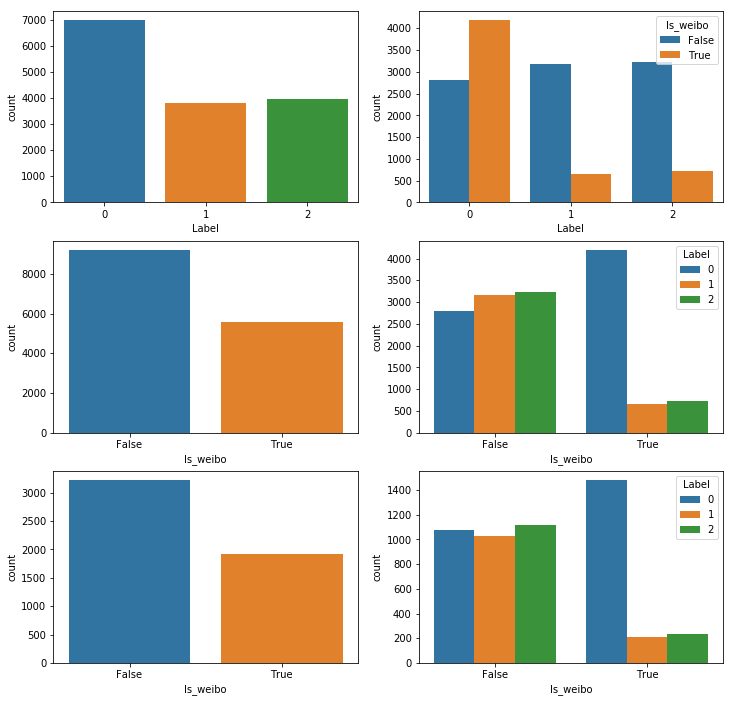

In [210]:
f,ax = plt.subplots(3,2,figsize=(12,12))
sb.countplot(x='Label',data=train_dataset,ax=ax[0,0],)
sb.countplot(x='Label',hue='Is_weibo',data=train_dataset,ax=ax[0,1],)
sb.countplot(x='Is_weibo',data=train_dataset,ax=ax[1,0],)
sb.countplot(x='Is_weibo',hue='Label',data=train_dataset,ax=ax[1,1],)

sb.countplot(x='Is_weibo',data=dev_dataset,ax=ax[2,0],)
sb.countplot(x='Is_weibo',hue='Label',data=dev_dataset,ax=ax[2,1],)

/home/jasonhaven/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


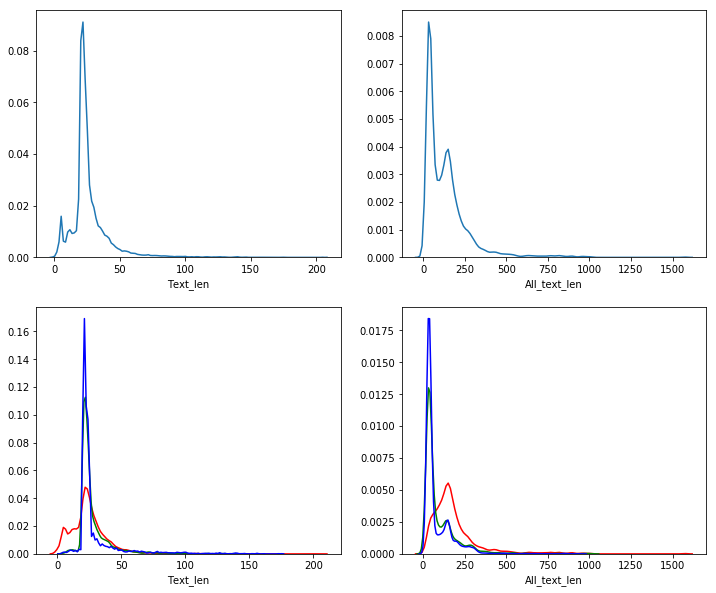

In [190]:
f,ax = plt.subplots(2,2,figsize=(12,10))
sb.distplot(train_dataset['Text_len'],hist=False,ax=ax[0,0])
sb.distplot(train_dataset['All_text_len'],hist=False,ax=ax[0,1])

sb.distplot(train_dataset[train_dataset['Label']==0]['Text_len'],hist=False,color='r',ax=ax[1,0])
sb.distplot(train_dataset[train_dataset['Label']==1]['Text_len'],hist=False,color='g',ax=ax[1,0])
sb.distplot(train_dataset[train_dataset['Label']==2]['Text_len'],hist=False,color='b',ax=ax[1,0])

sb.distplot(train_dataset[train_dataset['Label']==0]['All_text_len'],hist=False,color='r',ax=ax[1,1])
sb.distplot(train_dataset[train_dataset['Label']==1]['All_text_len'],hist=False,color='g',ax=ax[1,1])
sb.distplot(train_dataset[train_dataset['Label']==2]['All_text_len'],hist=False,color='b',ax=ax[1,1])

/home/jasonhaven/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


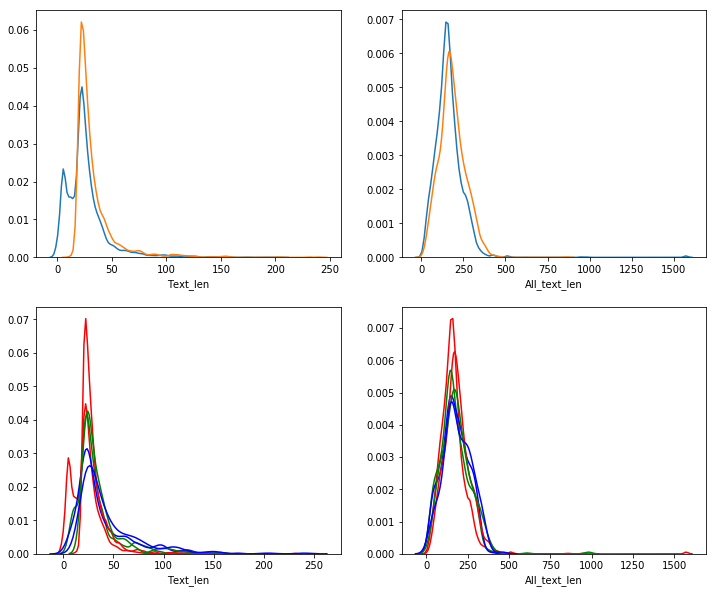

In [216]:
weibo1 = train_dataset[train_dataset['Is_weibo']]
weibo2 = dev_dataset[dev_dataset['Is_weibo']]

f,ax = plt.subplots(2,2,figsize=(12,10))


sb.distplot(weibo1['Text_len'],hist=False,ax=ax[0,0])
sb.distplot(weibo1['All_text_len'],hist=False,ax=ax[0,1])

sb.distplot(weibo1[weibo1['Label']==0]['Text_len'],hist=False,color='r',ax=ax[1,0])
sb.distplot(weibo1[weibo1['Label']==1]['Text_len'],hist=False,color='g',ax=ax[1,0])
sb.distplot(weibo1[weibo1['Label']==2]['Text_len'],hist=False,color='b',ax=ax[1,0])

sb.distplot(weibo1[weibo1['Label']==0]['All_text_len'],hist=False,color='r',ax=ax[1,1])
sb.distplot(weibo1[weibo1['Label']==1]['All_text_len'],hist=False,color='g',ax=ax[1,1])
sb.distplot(weibo1[weibo1['Label']==2]['All_text_len'],hist=False,color='b',ax=ax[1,1])

sb.distplot(weibo2['Text_len'],hist=False,ax=ax[0,0])
sb.distplot(weibo2['All_text_len'],hist=False,ax=ax[0,1])

sb.distplot(weibo2[weibo2['Label']==0]['Text_len'],hist=False,color='r',ax=ax[1,0])
sb.distplot(weibo2[weibo2['Label']==1]['Text_len'],hist=False,color='g',ax=ax[1,0])
sb.distplot(weibo2[weibo2['Label']==2]['Text_len'],hist=False,color='b',ax=ax[1,0])

sb.distplot(weibo2[weibo2['Label']==0]['All_text_len'],hist=False,color='r',ax=ax[1,1])
sb.distplot(weibo2[weibo2['Label']==1]['All_text_len'],hist=False,color='g',ax=ax[1,1])
sb.distplot(weibo2[weibo2['Label']==2]['All_text_len'],hist=False,color='b',ax=ax[1,1])

In [217]:
weibo[weibo['Label']==0][['Text','Label']]

,Text,Label
9,北京时间24日凌晨，2012年斯德哥尔摩室内田径赛正在进行。,0
10,奥运会亚军选手曾经学过Breaking?,0
11,当今之世，是一个东南西北中，各有各的口味的时代。,0
12,这个时代，也有跟这个时代相匹配的传播条件。,0
13,靠太像了啊啊啊 [PER] 在看春晚么？,0
14,[PER],0
15,两个娘娘腔，两只小人妖。,0
16,[PER] 据说，刘谦和傅琰东将同时亮相2012年CCTV龙年春晚的舞台。,0
55,林丹口型！！！,0
56,老娘心中有千万匹草泥马在狂奔！,0


In [232]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import jieba
from sklearn.naive_bayes import MultinomialNB


def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

X_train,y_train = train_dataset['Text'].values,train_dataset['Label'].values
X_dev,y_dev = dev_dataset['Text'].values,dev_dataset['Label'].values

stopwords = stopwordslist('stopword.txt')

#分词
for i in range(X_train.shape[0]):
    sentence = ' '.join(w.strip() for w in jieba.cut(X_train[i]) if w.strip() not in stopwords)
    X_train[i] = sentence
for i in range(X_dev.shape[0]):
    sentence = ' '.join(w.strip() for w in jieba.cut(X_dev[i]) if w.strip() not in stopwords)
    X_dev[i] = sentence

X_train_without_weibo,y_train_without_weibo = X_train[train_dataset['Is_weibo']==False],y_train[train_dataset['Is_weibo']==False]
X_dev_without_weibo,y_dev_without_weibo = X_dev[dev_dataset['Is_weibo']==False],y_dev[dev_dataset['Is_weibo']==False]

X_train_weibo,y_train_weibo = X_train[train_dataset['Is_weibo']==True],y_train[train_dataset['Is_weibo']==True]
X_dev_weibo,y_dev_weibo = X_dev[dev_dataset['Is_weibo']==True],y_dev[dev_dataset['Is_weibo']==True]

In [228]:
X_train_without_weibo.shape,X_train_weibo.shape

((9207,), (5581,))

In [230]:
X_dev_without_weibo.shape,X_dev_weibo.shape

((3220,), (1925,))

In [236]:
X_train_weibo

array(['领悟 透 泪 泪', 'PER 说定了 ! 心 萌', '喔 唷 奥特曼', ...,
       '中西 合璧 席琳迪翁 宋祖英 合唱 茉莉花',
       '转发 东方 财富网 微博 股市 套现 百亿元 乐视 贾跃亭 12 亿 银行存款 冻结 乐视 金融机构 偿还 100 多亿元 贷款 非上市 体系 资金 报道 称乐视 供应商 欠款 级别',
       '150 亿 打水漂 150 亿 撬动 2700 杠杆 资金 搏 一搏 绝大多数 企业家 眼睁睁 打水漂 贾跃亭 缺乏 一股 狠劲'],
      dtype=object)

#### tfidf/count LR

100%|██████████| 10/10 [05:42<00:00, 34.99s/it]
No handles with labels found to put in legend.


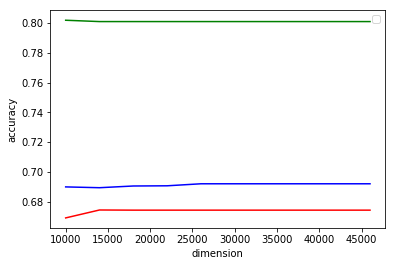

In [248]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

k=list(range(10000,50000,4000))

k_tfidf_score_all=[]
k_tfidf_score_weibo=[]
k_tfidf_score_notweibo=[]

for i in tqdm(k):
    tfidf=TfidfVectorizer(token_pattern=r"(?u)\b\w+\b",max_features=i,min_df=2,ngram_range=(1,4))
    
    X_tfidf=tfidf.fit_transform(X_train)
    model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    scores_tfidf=cross_val_score(model,X_tfidf,y_train,cv=10,scoring='accuracy')
    score_tfidf=scores_tfidf.mean()
    k_tfidf_score_all.append(score_tfidf)
    
    X_tfidf=tfidf.fit_transform(X_train_weibo)
    model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    scores_tfidf=cross_val_score(model,X_tfidf,y_train_weibo,cv=10,scoring='accuracy')
    score_tfidf=scores_tfidf.mean()
    k_tfidf_score_weibo.append(score_tfidf)
    
    X_tfidf=tfidf.fit_transform(X_train_without_weibo)
    model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    scores_tfidf=cross_val_score(model,X_tfidf,y_train_without_weibo,cv=10,scoring='accuracy')
    score_tfidf=scores_tfidf.mean()
    k_tfidf_score_notweibo.append(score_tfidf)
    
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.plot(k,k_tfidf_score_all,color='blue')
plt.plot(k,k_tfidf_score_weibo,color='green')
plt.plot(k,k_tfidf_score_notweibo,color='red')
plt.legend()
plt.show()

In [270]:
def score(y_true,y_pred):
    print('acc:',accuracy_score(y_true,y_pred))
    print('precision:',precision_score(y_true,y_pred,average='macro'))
    print('recall:',recall_score(y_true,y_pred,average='macro'))
    print('f1:',f1_score(y_true,y_pred,average='macro'))
    
# 转换为tfidf特征
tfidf=TfidfVectorizer(token_pattern=r"(?u)\b\w+\b",max_features=15000,ngram_range=(1,2),min_df=2)

X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_dev = tfidf.transform(X_dev)

X_tfidf_train_weibo = tfidf.fit_transform(X_train_weibo)
X_tfidf_dev_weibo = tfidf.transform(X_dev_weibo)

X_tfidf_train_without_weibo = tfidf.fit_transform(X_train_without_weibo)
X_tfidf_dev_without_weibo = tfidf.transform(X_dev_without_weibo)

print('train shape:',X_tfidf_train.shape)
print('dev shape:',X_tfidf_dev.shape)
print('train_label shape',y_train.shape)
print()
print('weibo train shape:',X_tfidf_train_weibo.shape)
print('weibo dev shape:',X_tfidf_dev_weibo.shape)
print('weibo train_label shape',y_train_weibo.shape)
print()
print('without weibo train shape:',X_tfidf_train_without_weibo.shape)
print('without weibo dev shape:',X_tfidf_dev_without_weibo.shape)
print('without weibo train_label shape',y_train_without_weibo.shape)

train shape: (14788, 15000)
dev shape: (5145, 15000)
train_label shape (14788,)

weibo train shape: (5581, 7498)
weibo dev shape: (1925, 7498)
weibo train_label shape (5581,)

without weibo train shape: (9207, 11237)
without weibo dev shape: (3220, 11237)
without weibo train_label shape (9207,)


In [271]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.naive_bayes import MultinomialNB

print('朴素贝叶斯')

print('all')
model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
model.fit(X_tfidf_train,y_train)
prediction = model.predict(X_tfidf_dev)
score(y_dev,prediction)

print('weibo')
model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
model.fit(X_tfidf_train_weibo,y_train_weibo)
prediction = model.predict(X_tfidf_dev_weibo)
score(y_dev_weibo,prediction)

print('not weibo')
model = LogisticRegression(solver='lbfgs',multi_class='multinomial')
model.fit(X_tfidf_train_without_weibo,y_train_without_weibo)
prediction = model.predict(X_tfidf_dev_without_weibo)
score(y_dev_without_weibo,prediction)

朴素贝叶斯
all
acc: 0.6777453838678329
precision: 0.6459245514692092
recall: 0.624549143334559
f1: 0.6314319810119442
weibo
acc: 0.8145454545454546
precision: 0.6305149854469482
recall: 0.48432771463462004
f1: 0.5062422420990882
not weibo
acc: 0.665527950310559
precision: 0.667151103216677
recall: 0.6637459570714496
f1: 0.6647005114474994


In [260]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs',multi_class='auto')
model.fit(X_tfidf_train_weibo,y_train_weibo)

prediction = model.predict(X_tfidf_dev_weibo)
print('LR with weibo')
print('acc:',accuracy_score(y_dev,prediction))
print('precision:',precision_score(y_dev,prediction,average='macro'))
print('recall:',recall_score(y_dev,prediction,average='macro'))
print('f1:',f1_score(y_dev,prediction,average='macro'))

LR with weibo
acc: 0.7352769679300292
precision: 0.7073715555970086
recall: 0.6960898625236092
f1: 0.7003211400487884


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [261]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs',multi_class='auto')
model.fit(X_tfidf_train_without_weibo,y_train_without_weibo)

prediction = model.predict(X_tfidf_dev_without_weibo)
print(prediction.shape,y_dev_weibo.shape)
#微博的全预测为0
prediction = np.append(prediction,[0]*len(y_dev_weibo))
assert prediction.shape[0]==3335+1810
true = np.append(y_dev_without_weibo,y_dev_weibo)
print(prediction)
print('LR without weibo')
print('acc:',accuracy_score(true,prediction))
print('precision:',precision_score(true,prediction,average='macro'))
print('recall:',recall_score(true,prediction,average='macro'))
print('f1:',f1_score(true,prediction,average='macro'))

(3335,) (1810,)
[0 2 1 ... 0 0 0]
LR without weibo
acc: 0.7500485908649174
precision: 0.7272495039686252
recall: 0.7000661762079714
f1: 0.7099850034413219


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
sns.catplot(x="Label", hue="Is_weibo", col="survived",data=titanic, kind="count",height=4, aspect=.7);

In [224]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_tfidf_train,y_train)

prediction = model.predict(X_tfidf_dev)
print('SVC')
print('acc:',accuracy_score(y_dev,prediction))
print('precision:',precision_score(y_dev,prediction,average='macro'))
print('recall:',recall_score(y_dev,prediction,average='macro'))
print('f1:',f1_score(y_dev,prediction,average='macro'))

F:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC
acc: 0.49640427599611275
precision: 0.16546809199870424
recall: 0.3333333333333333
f1: 0.22115426245832792


F:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [225]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_tfidf_train,y_train)

prediction = model.predict(X_tfidf_dev)
print('Xgboost')
print('acc:',accuracy_score(y_dev,prediction))
print('precision:',precision_score(y_dev,prediction,average='macro'))
print('recall:',recall_score(y_dev,prediction,average='macro'))
print('f1:',f1_score(y_dev,prediction,average='macro'))

Xgboost
acc: 0.6843537414965987
precision: 0.6778290663738032
recall: 0.6051540484365179
f1: 0.61535106655456
